<a href="https://colab.research.google.com/github/risazhrn/IndoBert-Review-Hotel/blob/main/Finetuning_Model_IndoBERT_Hotel_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets pandas seaborn matplotlib deep-translator tqdm transformers evaluate accelerate scikit-learn langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=6af58c63c84fe5b915183e5b1d2fb427d79c78087cc76e2914ab62bdb381e21a
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import string
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from google.colab import drive


# Mengaktifkan progress bar untuk Pandas
tqdm.pandas()

# Supaya hasil deteksi bahasa konsisten
DetectorFactory.seed = 0

# Inisialisasi Translator
translator = GoogleTranslator(source='auto', target='id')

drive.mount('/content/drive')

In [ ]:
# --- LANGKAH 1: LOAD DATASET ---

print("Sedang memuat dataset...")
# Dataset Utama (Indo)
ds_main = load_dataset("rakkaalhazimi/hotel-review", split='train')
df_main = pd.DataFrame(ds_main)

# Dataset Sekunder (Inggris)
ds_sec = load_dataset("CocoRoF/hotel_review_data", split='train')
df_sec = pd.DataFrame(ds_sec)

print("Dataset berhasil dimuat")

Sedang memuat dataset...


README.md:   0%|          | 0.00/366 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/11142 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3714 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/450 [00:00<?, ?B/s]

data/train-00000-of-00001-ef5c392c32f3c7(…):   0%|          | 0.00/68.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/192957 [00:00<?, ? examples/s]

Dataset berhasil dimuat


In [ ]:
# 1. Load Dataset Utama (yang berisi train & test)
ds_main_dict = load_dataset("rakkaalhazimi/hotel-review")

# 2. Konversi ke DataFrame & Gabungkan
df_train = pd.DataFrame(ds_main_dict['train'])
df_test = pd.DataFrame(ds_main_dict['test'])

# Gabungkan (Merge) dataset Train dan Test
df_main = pd.concat([df_train, df_test], ignore_index=True)

# 3. Proses Labeling (Sesuai request kamu)
# Note: Nama kolom aslinya 'label', bukan 'labels'
df_main['label_final'] = df_main['labels'].apply(lambda x: 2 if x == 1 else 0)

# Ambil kolom final
df_main_final = df_main[['text', 'label_final']]

# Pisahkan untuk menghitung jumlah (menggunakan kolom asli 'label')
df_negative = df_main[df_main['labels'] == 0]
df_positive = df_main[df_main['labels'] == 1]

# 4. Print Hasil
print(f"Total Data Negatif : {len(df_negative)} baris")
print(f"Total Data Positif : {len(df_positive)} baris")
print(f"   > Total data utama (Gabungan): {len(df_main_final)}")

Total Data Negatif : 12839 baris
Total Data Positif : 2017 baris
   > Total data utama (Gabungan): 14856


In [ ]:
df_sec['user_rating'] = df_sec['user_rating'].astype(float)

# Filter: Hanya ambil Rating 3.0 (Netral)
df_neutral = df_sec[df_sec['user_rating'] == 3.0].copy()

# Rename kolom text
df_neutral = df_neutral[['user_review']].rename(columns={'user_review': 'text'})

print(f"   > Ditemukan {len(df_neutral)} data rating 3 (Netral).")

   > Ditemukan 3581 data rating 3 (Netral).


In [ ]:
print("\n2. Memulai Terjemahan (English -> Indonesia)...")
print("   Harap bersabar, diberi jeda 1 detik per data agar tidak diblokir Google.")

def safe_translate(text):
    """
    Fungsi untuk menerjemahkan dengan penanganan error dan jeda waktu.
    """
    if pd.isna(text) or text == "":
        return None

    try:
        # Translate
        translated = GoogleTranslator(source='en', target='id').translate(text)
        # Jeda 1 detik (PENTING AGAR TIDAK KENA RATE LIMIT)
        time.sleep(1)
        return translated
    except Exception as e:
        # Jika gagal, kembalikan None agar bisa dibuang nanti
        return None

# Menerapkan fungsi ke seluruh data netral
# Progress bar akan muncul untuk estimasi waktu
df_neutral['text_indo'] = df_neutral['text'].progress_apply(safe_translate)

# Hapus data yang gagal diterjemahkan (jika ada)
df_neutral_clean = df_neutral.dropna(subset=['text_indo']).copy()
# Pakai kolom hasil terjemahan
df_neutral_final = df_neutral_clean[['text_indo']].rename(columns={'text_indo': 'text'})
df_neutral_final['label_final'] = 1 # Label 1 untuk Netral

print(f"   > Selesai. Total data netral bersih: {len(df_neutral_final)}")


2. Memulai Terjemahan (English -> Indonesia)...
   Harap bersabar, diberi jeda 1 detik per data agar tidak diblokir Google.


100%|██████████| 3581/3581 [2:12:21<00:00,  2.22s/it]

   > Selesai. Total data netral bersih: 3581


In [ ]:
# ==========================================
# TAHAP 4: PENGGABUNGAN (MERGE) & SHUFFLE
# ==========================================
print("\n4. Menggabungkan Dataset...")
df_final = pd.concat([df_main_final, df_neutral_final], ignore_index=True)

# Acak urutan data (Shuffle) agar saat training model tidak bias urutan
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"   > TOTAL DATASET GABUNGAN: {len(df_final)} baris")


4. Menggabungkan Dataset...
   > TOTAL DATASET GABUNGAN: 18437 baris


In [ ]:
# ==========================================
# TAHAP 5: SIMPAN DATASET (PENTING!)
# ==========================================

filename = "dataset_hotel_review.csv"
df_final.to_csv(filename, index=False)
print(f"\n5. Dataset berhasil disimpan sebagai '{filename}'")


5. Dataset berhasil disimpan sebagai 'dataset_hotel_review.csv'


/tmp/ipython-input-1476165649.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label_final', data=df_final, palette='viridis')



6. Statistik Akhir:
label_final
0    12839
1     3581
2     2017
Name: count, dtype: int64


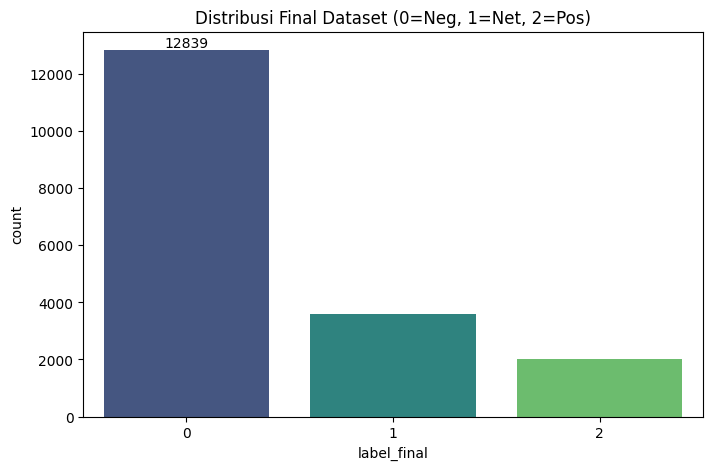

In [ ]:
# ==========================================
# TAHAP 6: FINAL CHECK DISTRIBUSI
# ==========================================
print("\n6. Statistik Akhir:")
print(df_final['label_final'].value_counts().sort_index())

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label_final', data=df_final, palette='viridis')
plt.title('Distribusi Final Dataset (0=Neg, 1=Net, 2=Pos)')
plt.bar_label(ax.containers[0])
plt.show()

In [ ]:
print("Total Data Awal:", len(df_final))

Total Data Awal: 18437


In [ ]:
norm_dict = {
    # --- NEGASI (Sangat Penting untuk Sentimen) ---
    "gak": "tidak", "ga": "tidak", "nggak": "tidak", "gk": "tidak",
    "g": "tidak", "tak": "tidak", "tdk": "tidak", "ngga": "tidak",
    "kaga": "tidak", "ndak": "tidak", "bukan": "bukan", "bkn": "bukan",
    "jangan": "jangan", "jgn": "jangan", "no": "tidak",

    # --- PENGUAT RASA (Intensifier) ---
    "bgt": "sangat", "banget": "sangat", "kali": "sangat", # "bersih kali" -> "bersih sangat"
    "bat": "sangat", "parah": "sangat", # "bagus parah" -> "bagus sangat"
    "beud": "sangat", "pisan": "sangat",
    "krn": "karena", "karna": "karena",

    # --- PRONOMINA (Kata Ganti Orang) ---
    "sy": "saya", "gw": "saya", "gue": "saya", "aku": "saya", "aq": "saya",
    "ak": "saya", "q": "saya", "kita": "kami", # Di review hotel, kita sering berarti kami
    "lu": "kamu", "lo": "kamu", "km": "kamu", "anda": "kamu",
    "kak": "kakak", "agan": "kakak", "sis": "kakak", "bro": "kakak",

    # --- KATA KERJA UMUM ---
    "nginep": "menginap", "nginap": "menginap", "inep": "menginap",
    "dtg": "datang", "sampe": "sampai", "nyampe": "sampai",
    "bilang": "berkata", "blg": "berkata",
    "pesen": "pesan", "psn": "pesan", "book": "pesan", "booking": "pesan",
    "dpt": "dapat", "dapet": "dapat",
    "buka": "buka", "tutup": "tutup",
    "makan": "makan", "minum": "minum",
    "checkin": "masuk", "checkout": "keluar",

    # --- KATA SIFAT (Adjective) - KUNCI SENTIMEN ---
    "bgs": "bagus", "good": "bagus", "nice": "bagus", "best": "terbaik",
    "jlk": "jelek", "ancur": "rusak", "bad": "buruk", "worst": "terburuk",
    "kotor": "kotor", "dekil": "kotor", "jorok": "kotor",
    "bersih": "bersih", "clean": "bersih", "rapih": "rapi",
    "nyaman": "nyaman", "comfy": "nyaman", "betah": "nyaman",
    "berisik": "bising", "rame": "ramai", "sepi": "sunyi",
    "dingin": "dingin", "panas": "panas", "gerah": "panas",
    "wangi": "harum", "bau": "bau", "apek": "bau",
    "mahal": "mahal", "murah": "murah", "pricey": "mahal",
    "worth": "layak", "worthit": "layak",
    "recomended": "direkomendasikan", "rekomen": "direkomendasikan",
    "rekomend": "direkomendasikan", "recom": "direkomendasikan",
    "kecewa": "kecewa", "nyesel": "menyesal", "kapok": "jera",

    # --- ISTILAH HOTEL / FASILITAS ---
    "ac": "pendingin ruangan", "ase": "pendingin ruangan",
    "wifi": "internet", "sinyal": "sinyal", "koneksi": "koneksi",
    "tv": "televisi", "remote": "remot",
    "bed": "kasur", "kasur": "kasur", "bantal": "bantal", "sprei": "seprai",
    "kamar": "kamar", "room": "kamar", "toilet": "kamar mandi", "wc": "kamar mandi",
    "bathup": "bak mandi", "shower": "pancuran", "air": "air", "water": "air",
    "panas": "panas", "hangat": "hangat",
    "kolam": "kolam renang", "pool": "kolam renang", "renang": "berenang",
    "resto": "restoran", "cafe": "kafe", "kantin": "kafe",
    "bfast": "sarapan", "breakfast": "sarapan", "sarapan": "sarapan",
    "makanan": "makanan", "menu": "menu",
    "resepsionis": "resepsionis", "receptionist": "resepsionis", "staff": "staf",
    "pelayan": "staf", "security": "satpam", "satpam": "satpam",
    "parkir": "parkir", "parkiran": "parkir", "basement": "bawah tanah",
    "lobby": "lobi", "lift": "lift", "tangga": "tangga",
    "lokasi": "lokasi", "deket": "dekat", "jauh": "jauh", "strategis": "strategis",

    # --- KATA SAMBUNG & LAINNYA ---
    "yg": "yang", "utk": "untuk", "untk": "untuk",
    "dg": "dengan", "dgn": "dengan", "sm": "dengan", "sama": "dengan",
    "dr": "dari", "dri": "dari",
    "di": "di", "ke": "ke",
    "tp": "tapi", "tpi": "tapi", "tetapi": "tapi", "but": "tapi",
    "kalo": "kalau", "kl": "kalau", "klo": "kalau",
    "pas": "ketika", "saat": "ketika", "wkt": "waktu",
    "udh": "sudah", "sdh": "sudah", "dah": "sudah",
    "blm": "belum", "blom": "belum",
    "dlm": "dalam", "luar": "luar",
    "bnyk": "banyak", "byk": "banyak", "banyak": "banyak",
    "dikit": "sedikit", "sdkt": "sedikit",
    "kurang": "kurang", "krg": "kurang",
    "lebih": "lebih", "lbh": "lebih",
    "cuma": "hanya", "cman": "hanya", "hanya": "hanya",
    "aja": "saja", "aj": "saja", "doang": "saja",
    "sih": "", "deh": "", "dong": "", "kok": "", "mah": "", "tuh": "", # Filler words dihapus
    "bs": "bisa", "bisa": "bisa", "gabisa": "tidak bisa",
    "mau": "ingin", "mo": "ingin", "pengen": "ingin",
    "ok": "oke", "oke": "oke", "sip": "oke", "siip": "oke", "y": "iya"
}

In [ ]:
# =====================================================================
# FUNGSI PREPROCEESING
# =====================================================================
def smart_preprocessing(text):
    if not isinstance(text, str): return ""

    # --- TAHAP A: BASIC CLEANING (Supaya deteksi bahasa akurat) ---
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text) # Hapus hashtag
    text = re.sub(r'http\S+', ' ', text)        # Hapus URL
    text = re.sub(r'\d+', '', text)             # Hapus angka
    # Hapus emoji/karakter aneh SEBELUM translate (biar gak error)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if text == "": return ""

    # --- TAHAP B: DETEKSI & TERJEMAHKAN ---
    # Kita hanya cek bahasa jika kalimatnya cukup panjang (> 2 kata)
    # Teks pendek (misal "oke sip") sering salah deteksi jadi bahasa asing
    if len(text.split()) > 2:
        try:
            lang = detect(text)
            # Jika TERDETEKSI BUKAN INDONESIA (dan bukan 'ms' melayu yg mirip)
            if lang not in ['id', 'ms', 'ind']:
                # Terjemahkan!
                text = translator.translate(text)
        except:
            pass # Jika gagal deteksi/translate, biarkan apa adanya

    # --- TAHAP C: NORMALISASI SLANG (Setelah jadi Indo) ---
    # Kenapa di akhir? Karena hasil translate biasanya baku,
    # tapi teks asli Indo yang 'alay' perlu diperbaiki di sini.
    text = text.lower() # Pastikan lowercase lagi hasil translatenya
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) # Hapus tanda baca

    words = text.split()
    mapped_words = [norm_dict.get(w, w) for w in words]
    text = " ".join(mapped_words)

    # Hapus spasi ganda sisa
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
print("\nSedang melakukan preprocessing (Cleaning)...")

# Kita gunakan tqdm agar kelihatan jalan prosesnya
tqdm.pandas()

# Terapkan ke dataframe
df_final['text_clean'] = df_final['text'].progress_apply(smart_preprocessing)

# Filter data kosong (jika ada sisa)
df_ready = df_final[df_final['text_clean'] != ""].copy()
df_ready = df_ready[['text_clean', 'label_final']]

print("-" * 40)
print(f"SELESAI! Total Data Bersih: {len(df_ready)}")
print("-" * 40)

# Cek Contoh Hasil (Ambil sampel acak)
print("Contoh Hasil:")
print(df_ready.sample(5)['text_clean'])


Sedang melakukan preprocessing (Cleaning)...


100%|██████████| 18437/18437 [07:35<00:00, 40.45it/s]

----------------------------------------
SELESAI! Total Data Bersih: 18416
----------------------------------------
Contoh Hasil:
1545     seprai dengan sarung bantal tidak diganti air ...
14490    air di kamar mandi keluarnya kecil tidak lanca...
2605     pelayanan baik harga tidak sesuai pesanan kama...
4730     kamarnya kecil sangat air panas baik tapi clos...
12511                           untuk sower kurang terawat
Name: text_clean, dtype: object


/tmp/ipython-input-1016263851.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_final', data=df_balanced, palette='viridis')



=== 1. Memulai Penyeimbangan Data ===
Target jumlah per kelas (mengikuti Netral): 3581

Distribusi Final (Seimbang):
label_final
1    3581
0    3581
2    3581
Name: count, dtype: int64


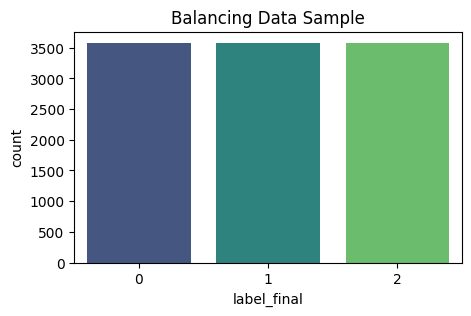

In [ ]:
# ==========================================
# LANGKAH 1: BALANCING (HYBRID SAMPLING)
# ==========================================
print("\n=== 1. Memulai Penyeimbangan Data ===")

# Pisahkan data berdasarkan kelas
df_neg = df_ready[df_ready['label_final'] == 0] # Negatif
df_net = df_ready[df_ready['label_final'] == 1] # Netral
df_pos = df_ready[df_ready['label_final'] == 2] # Positif

# Kita gunakan jumlah NETRAL sebagai patokan target
n_samples = len(df_net)
print(f"Target jumlah per kelas (mengikuti Netral): {n_samples}")

# A. Downsample Negatif (Kurangi jumlahnya)
df_neg_bal = resample(df_neg,
                      replace=False,    # Tidak boleh ada duplikasi (karena membuang)
                      n_samples=n_samples,
                      random_state=42)

# B. Oversample Positif (Tambah/Duplikasi jumlahnya)
df_pos_bal = resample(df_pos,
                      replace=True,     # Boleh duplikasi
                      n_samples=n_samples,
                      random_state=42)

# C. Netral biarkan apa adanya
df_net_bal = df_net

# D. Gabungkan Semuanya
df_balanced = pd.concat([df_neg_bal, df_net_bal, df_pos_bal])

# E. Acak Urutan (Shuffle) agar tidak berkelompok
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek Visualisasi Akhir
print("\nDistribusi Final (Seimbang):")
print(df_balanced['label_final'].value_counts())

plt.figure(figsize=(5, 3))
sns.countplot(x='label_final', data=df_balanced, palette='viridis')
plt.title('Balancing Data Sample')
plt.show()

In [ ]:
# ==========================================
# LANGKAH 2: SPLITTING (TRAIN / VAL / TEST)
# ==========================================
print("\n=== 2. Membagi Data (Split) ===")

# Skema Pembagian: Train (80%), Validation (10%), Test (10%)

# Tahap A: Pisahkan Test (10%) dari total data
train_val, test = train_test_split(
    df_balanced,
    test_size=0.1,
    random_state=42,
    stratify=df_balanced['label_final'] # Stratify wajib agar proporsi kelas terjaga
)

# Tahap B: Pisahkan Validation (10%) dari sisa data (Train+Val)
# Sisa data adalah 90%. Untuk mendapatkan 10% dari total awal,
# kita ambil 1/9 (sekitar 0.1111) dari sisa data tersebut.
train, val = train_test_split(
    train_val,
    test_size=0.1111,
    random_state=42,
    stratify=train_val['label_final']
)

print(f"Jumlah Data Train : {len(train)}")
print(f"Jumlah Data Val   : {len(val)}")
print(f"Jumlah Data Test  : {len(test)}")


=== 2. Membagi Data (Split) ===
Jumlah Data Train : 8593
Jumlah Data Val   : 1075
Jumlah Data Test  : 1075


In [ ]:
print("\n=== 3. Menyimpan File ===")

train.to_csv("data_train_final.csv", index=False)
val.to_csv("data_val_final.csv", index=False)
test.to_csv("data_test_final.csv", index=False)

print("SUKSES! 3 file CSV telah dibuat dan siap untuk Fine-Tuning.")


=== 3. Menyimpan File ===
SUKSES! 3 file CSV telah dibuat dan siap untuk Fine-Tuning.


In [ ]:
print("Sedang memuat data dari file CSV...")
data_files = {
    "train": "data_train_final.csv",
    "validation": "data_val_final.csv",
    "test": "data_test_final.csv"
}

# Load dataset menggunakan format CSV
dataset = load_dataset("csv", data_files=data_files)
dataset = dataset.rename_column("label_final", "label")

print("Struktur Dataset:")
print(dataset)

Sedang memuat data dari file CSV...


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Struktur Dataset:
DatasetDict({
    train: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 8593
    })
    validation: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 1075
    })
    test: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 1075
    })
})


In [ ]:
# ========================================================
# TOKENISASI (TEKS -> ANGKA)
# ========================================================
# Kita gunakan IndoBERT Base Phase 1 (Model standar yang bagus)
model_checkpoint = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    # Ubah teks jadi angka. Max length 128 cukup hemat memori & cepat.
    return tokenizer(examples["text_clean"], truncation=True, max_length=128)

print("\nSedang melakukan Tokenisasi...")
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Data Collator: Mengatur batch agar panjangnya seragam saat masuk GPU
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Sedang melakukan Tokenisasi...


Map:   0%|          | 0/8593 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

In [ ]:
# ========================================================
# PERSIAPAN MODEL & METRIK
# ========================================================

# Definisi Label (Agar outputnya bukan cuma angka 0,1,2)
id2label = {0: "NEGATIF", 1: "NETRAL", 2: "POSITIF"}
label2id = {"NEGATIF": 0, "NETRAL": 1, "POSITIF": 2}

# Load Model Pre-trained
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3, # PENTING: Kita punya 3 kelas!
    id2label=id2label,
    label2id=label2id
)

# Siapkan Metrik Evaluasi (Akurasi & F1 Score)
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
# ========================================================
# 5. SETTING TRAINING (HYPERPARAMETERS)
# ========================================================
training_args = TrainingArguments(
    output_dir="./training_indobert_hotel", # Folder output sementara
    learning_rate=2e-5,              # Kecepatan belajar (Standar BERT)
    per_device_train_batch_size=16,  # Jumlah data sekali masuk (16 aman utk GPU Colab)
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # 3 Putaran sudah cukup pintar
    weight_decay=0.01,
    eval_strategy="epoch",     # Uji model setiap 1 epoch selesai
    save_strategy="epoch",           # Simpan model setiap 1 epoch selesai
    load_best_model_at_end=True,     # Ambil model terbaik di akhir
    metric_for_best_model="accuracy",
    report_to="none"                 # Matikan laporan ke WandB biar simple
)

# ========================================================
# 6. EKSEKUSI TRAINING
# ========================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n=== MULAI TRAINING (FINE-TUNING) ===")
print("Silakan tunggu, proses ini memakan waktu sekitar 10-20 menit tergantung GPU.")
trainer.train()

/tmp/ipython-input-1850997325.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



=== MULAI TRAINING (FINE-TUNING) ===
Silakan tunggu, proses ini memakan waktu sekitar 10-20 menit tergantung GPU.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.218000,0.203774,0.945116,0.944645
2,0.101900,0.143062,0.965581,0.965601
3,0.048200,0.152188,0.966512,0.966419


TrainOutput(global_step=1614, training_loss=0.11566540358825834, metrics={'train_runtime': 642.7179, 'train_samples_per_second': 40.109, 'train_steps_per_second': 2.511, 'total_flos': 1667730523147290.0, 'train_loss': 0.11566540358825834, 'epoch': 3.0})

Sedang menghitung prediksi pada data test...



LAPORAN EVALUASI MODEL (METRICS)
AKURASI TOTAL: 97.49%

              precision    recall  f1-score   support

     NEGATIF       0.98      0.94      0.96       358
      NETRAL       1.00      1.00      1.00       358
     POSITIF       0.94      0.98      0.96       359

    accuracy                           0.97      1075
   macro avg       0.98      0.97      0.97      1075
weighted avg       0.98      0.97      0.97      1075


CONFUSION MATRIX


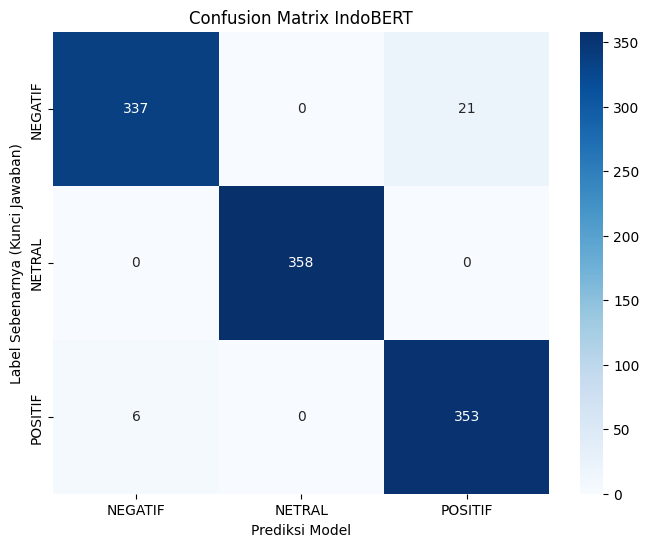

In [ ]:
print("Sedang menghitung prediksi pada data test...")
predictions_output = trainer.predict(tokenized_datasets["test"])

# Ambil hasil prediksi (logits) dan ubah jadi angka kelas (0, 1, 2)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# Definisi nama kelas biar enak dibaca
target_names = ["NEGATIF", "NETRAL", "POSITIF"]

# ========================================================
# 2. TAMPILKAN METRIK ANGKA (Classification Report)
# ========================================================
print("\n" + "="*50)
print("LAPORAN EVALUASI MODEL (METRICS)")
print("="*50)

# Tampilkan Akurasi Total
acc = accuracy_score(labels, preds)
print(f"AKURASI TOTAL: {acc:.2%}\n")

# Tampilkan Precision, Recall, F1-Score per kelas
print(classification_report(labels, preds, target_names=target_names))

# ========================================================
# 3. TAMPILKAN CONFUSION MATRIX (Visualisasi)
# ========================================================
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

# Buat matriks
cm = confusion_matrix(labels, preds)

# Plot menggunakan Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (Kunci Jawaban)')
plt.title('Confusion Matrix IndoBERT')
plt.show()

In [ ]:
# Save to drive google
model.save_pretrained('/content/drive/MyDrive/hotel model')